# Random Projections

### Rishi Advani, Madison Crim, Sean O'Hagan

#### July 10, 2020

# Eigenfaces

In order to apply some of our work, we decided to apply the deterministic and randomized variants of the SVD on a larger dataset. We chose to use the [LFW](http://vis-www.cs.umass.edu/lfw/) (labeled faces in the wild) dataset, containing ~$8000$ $250\times 250$ RGB images. We load a subset (1000 images) of the data and center it as follows:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%cd ..
from eigenutil import *
%cd -
from leastsquares import*

C:\Users\Sean\random-projections
C:\Users\Sean\random-projections\presentations


### Examples

Let's look at some of the faces in the dataset.

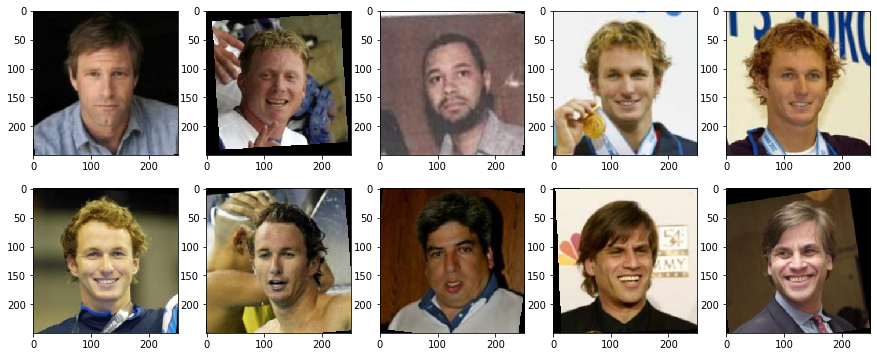

In [3]:
plot_examples(2,5)

We can flatten each image to represent it as vector of length $250\cdot 250 \cdot 3 = 187500$. This yields a data matrix $A$ of size $(1000,187500)$, which we may now manipulate. After computing the singular value decomposition,
$$A = U \Sigma V^* \,,$$
the columns of $U$ represent an orthonormal basis for the span of the original data, ordered in accordance to their corresponding singular values, from greatest to least. Thus, we may truncate $U$ and use the first $k$ columns as a basis for rank $k$ approximation.

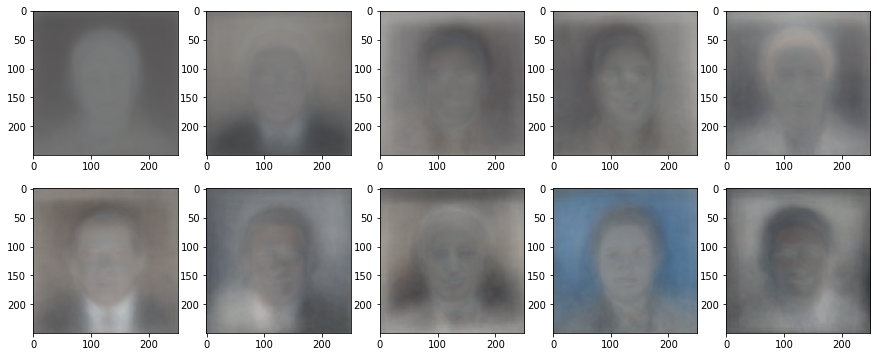

In [4]:
plot_eigenfaces(normalized_det_basis, 2, 5)

Similarly to deterministic SVD, we may utilize random SVD for this task as well. As a refresher, given a desired rank $k$ and an oversampling parameter $p$, we compute a randomized SVD in the following way:

- Define $l=k+p$.
- Let $\Omega \in \mathbb{R}^{n\times l}$, with $\Omega_{ij} \sim N(0,1)$
- Define $Y = A \Omega$
- Compute an orthonormal basis for the columns of $Y$ (i.e. with $QR$ decomposition)
- Define $B = Q^* A$. Note $B$ has dimension $l\times n$
- Compute the SVD of B, $B=\tilde{U}\Sigma V^*$, and let $U = Q\tilde{U}$, yielding $A\approx U\Sigma V^*$

Below are the columns of $U$ obtained using Randomized SVD:

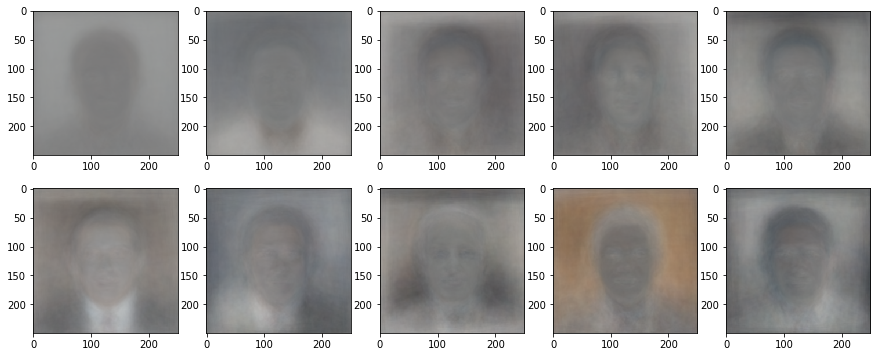

In [5]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

~~~

Now that we have a basis, we may represent arbitrary vectors in our image space as linear combinations of basis vectors. To do this, we solve the linear system
$$A\vec{x}=\vec{b}-m \,,$$
where $A$ denotes the matrix of which our basis vectors are columns, $\vec{b}$ denotes our specific image, and $m$ denotes the (column) mean of the dataset. Since we know our basis is orthonormal, we can use a shortcut, computing the coefficients $\vec{x}$ as 
$$\vec{x} = (\vec{b}-m)A \,.$$

Below are examples of approximating images at a certain rank after a change of basis. The reason why this technique is useful is that any arbitrary image thought to be similar to those in the dataset may be represented fairly well using this basis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


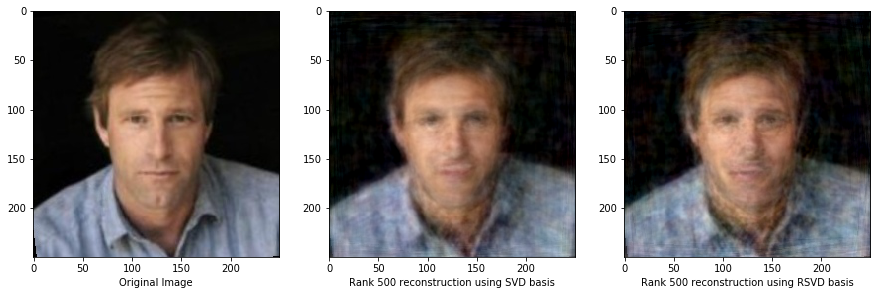

In [6]:
reconstruct(specific_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


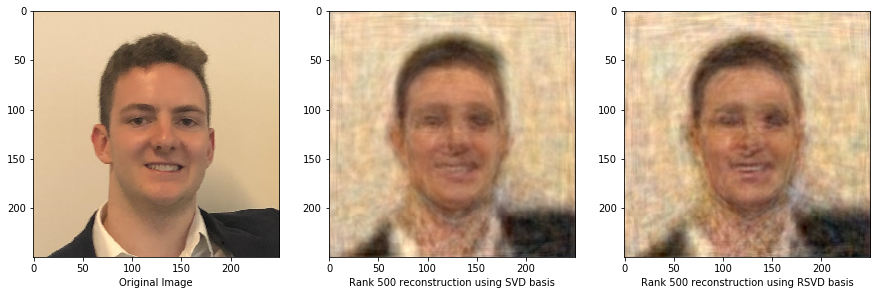

In [7]:
sean = np.asarray(Image.open('../examples/sean250.png')).flatten() / 255
reconstruct(sean)

Please enjoy the follow animations:

Aaron Eckhart | Sean | President Obama | Ellie Goulding
- | - | - | -
![Guy](../examples/guy250.png) | ![Sean](../examples/sean250.png) | ![Pres](../examples/president_obama250.png) | ![Ellie](../examples/ellie250.png)
![Anim](../examples/guy.gif) | ![Anim](../examples/sean.gif) | ![Anim](../examples/pres.gif) | ![Anim](../examples/ellie.gif)


### How to get better results?

- Use more data or a larger dataset
- Train with data that is representative of the data you wish to test with
- Standardize the position and scale of the face within the image

~~~

We now perform an analysis on the cost and accuracy of these methods, as the rank $k$ of the approximation varies. We see an inverse relationship between these quantities, as expected.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:32<00:00, 83.20s/it]


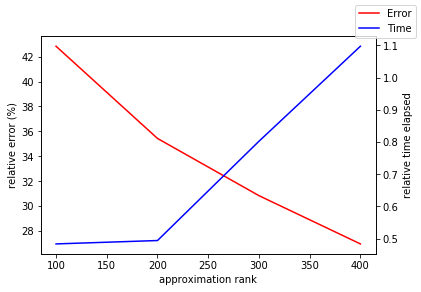

In [12]:
domain = np.arange(100, 500, step=100)

rand_times = []
errors = []

for k in tqdm(domain):
    
    det_basis = svd_rank_k(k)
    det_approx = det_basis @ np.diag(SSigma[:k]) @ VVh[:k]
    
    start = perf_counter()
    rand_approx = rsvd_rank_k(k, return_approx=True)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    error = 100 * np.linalg.norm(rand_approx - det_approx) / np.linalg.norm(det_approx) #relative error between rsvd and svd
    #if we want, we can look at relative error between rsvd and data as well
    errors.append(error)


fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error (%)')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right')

Finally, since the randomized SVD is a random process, we may sample it and provide statistical information. Again, due to concentration of measure, note the extremely low standard deviation in the error.

Sampling with rank k=100
Sampling with rank k=200
Sampling with rank k=300
Sampling with rank k=400


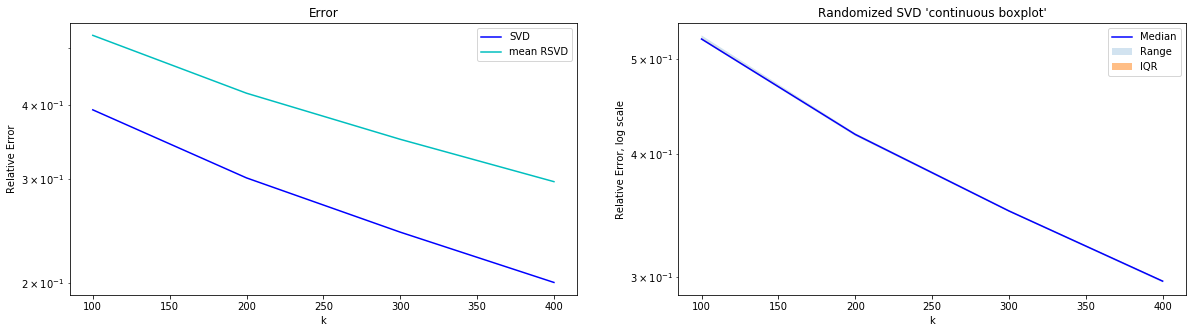

For k=200: Mean=0.29693339253673057, StDev=0.0004120264860488161


In [11]:
n_sample = 10
rsvd_error = np.empty((domain.shape[0], n_sample))
svd_error = np.empty(domain.shape[0])

rsvd_stat = np.empty((7,domain.shape[0]))

for i in tqdm(range(domain.shape[0])):
    print(f'Sampling with rank k={domain[i]}')
    svd_error[i] = np.linalg.norm((det_U[:,:domain[i]] @ np.diag(Sigma[:domain[i]]) @ VVh[:domain[i]]) - data) / np.linalg.norm(data)
    for j in range(n_sample):
        rsvd_error[i][j] = np.linalg.norm(rsvd_rank_k(domain[i],return_approx=True) - data) / np.linalg.norm(data)

for i in range(domain.shape[0]):
    rsvd_stat[0][i] = np.min(rsvd_error[i])
    rsvd_stat[1][i] = np.quantile(rsvd_error[i], 0.25)
    rsvd_stat[2][i] = np.median(rsvd_error[i])
    rsvd_stat[3][i] = np.quantile(rsvd_error[i], 0.75)
    rsvd_stat[4][i] = np.max(rsvd_error[i])
    rsvd_stat[5][i] = np.mean(rsvd_error[i])
    rsvd_stat[6][i] = np.std(rsvd_error[i])

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(domain, svd_error, c='b', label='SVD')
ax[0].plot(domain, rsvd_stat[5], c='c', label='mean RSVD')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error')

ax[1].plot(domain, rsvd_stat[2], c='b', label='Median')
ax[1].fill_between(domain, rsvd_stat[4], rsvd_stat[0], alpha=0.2, label='Range', lw=1)
ax[1].fill_between(domain, rsvd_stat[1], rsvd_stat[3], alpha=0.5, label='IQR', lw=1)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')


plt.show()

print(f"For k=200: Mean={rsvd_stat[5][3]}, StDev={rsvd_stat[6][3]}")

~~~

# Least-Squares Approximation

In practice, when trying to solve a linear system of equations $Ax=b$, there may not be an exact solution. One way to find an 'almost solution' is to find the vector $x'$ such that $\lVert Ax'-b \rVert_2$ is minimized, where $A$ is a full rank $mxn$ matrix such that $m\geq n$. This least squares solution which works by minimizing the sum of the squares of the differences between the entries of $Ax'$ and $b$ and thus solving the solution $Ax=b$ as closely as possible.

If the system has an exact solution, $x'$ is precisely the value of $x$ that solves the system. The reasoning is as follows:

The system is solvable, so there is a vector $x$, such that $Ax=b$. Equivalently, there is a vector $x$ such that $Ax-b = 0$. Then, we have $\lVert Ax-b \rVert_2 = 0$. The L2 norm is nonnegative for all its inputs by definition, so the smallest value it can take is $0$. Thus, $x$ is the vector that minimizes the expression.

We generate a random system and then find the least-squares approximation using a deterministic QR-based method and a randomized method.

## Deterministic QR-based method
Our deterministic algorithm uses QR factorization to find $x'$ such that we can approximate the linear system $Ax=b$. Given that $A=QR$ we can come up with the equation $QRx=b$. Multiplying both sides by $Q^T$ and using that $Q$ has orthonormal columns we get $Q^TQRx=Q^Tb => Rx=Q^Tb$. Note that $R$ is a upper triangular matrix with positive diagnoal entries, so $R$ has an inverse. Thus we can find an approximation of $x$ using the equation $x'=R^{-1}Q^Tb$. We have conducted this experiment with different size matrices $A$ giving us the results below. 

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:32<00:00,  1.18it/s]


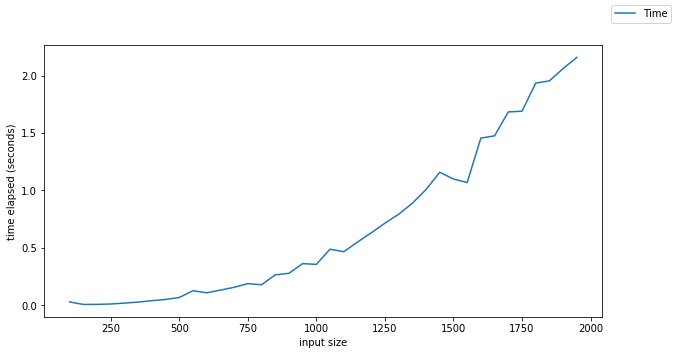

In [20]:
dims = np.arange(100, 2000, step=50)
times = ls(dims)
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('input size')

ax.plot(dims, times, label='Time')
ax.set_ylabel('time elapsed (seconds)')

fig.legend(loc='upper right')

## Randomized method
To solve the least squares problem we have devised a randomized method. Given an integer $k$, this method sample $k$ Gaussian $x$ vectors and will keep the random $x$ vector that best minimizes the distance $\lVert Ax-b \rVert_2$. We have constructed this algorithm so that it loops for multiple random $A$ matrices and $b$ vectors with entries from a standard normal distrbution. Our results show that although our randomized method provides evidence that this is an efficient method, the time elapsed grows at a greater rate then our deterministic method. However, this is not a flaw in our randomness but how we are sampling our data.

In [1]:
%cd

C:\Users\Crimmer


![graph](../presentations/random_methodls.png)

## Another Idea
Using a random matrix approximation, such as the ID, and then find a least squares solution for this approximation. Testing this with the ID gives better efficency since then the above randomized approach. However, it still fails to beat our current determinsitic approach.  

~~~

# What's Next?

We are currently interested in randomizing the kernel mapping in kernel PCA. While we do not wish to go in detail in this presentation, here is a quick demonstration:

Given the following data:

![Data](../examples/fakedata.png)

We want to find an embedding in which the two groups are linearly separable (and preferably well clustered). Regular PCA (linear kernel) will fail, as the polar symmetry in the data tells us that there is no direction (linear combination of the x and y axes) that accounts for significantly more variance in the data. In order to find meaningful principle components, we utilize kernel PCA, first mapping the data points into a higher dimensional space using a kernel function. Here are some embeddings of the data using various kernels and default parameters:

![Embeds](../examples/kpca_embeds.png)

As we can see, none of them are linearly separable. Often, we can find a better embedding by playing around with one of the parameters. Here is an animation of embeddings using the RBF/Gaussian kernel as the gamma parameter changes, $0<\gamma<26$.

![Anim](../examples/anim.gif)

While some values of gamma produce good nice/separable embeddings, choosing a value without guess and check is difficult. We are now investigating a randomized method for determining this kernel mapping, which produces nice output without having to arduously check parameters:

![RKPCA](../examples/rkpca.png)

# Thank you for listening!

### Questions?